In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation
from keras.layers import SimpleRNN
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
#drive.mount('/content/drive/')
##!ls "/content/drive/My Drive/"

import pandas as pd
# file_path = '/content/drive/My Drive/ParticipantData.csv'  # Replace 'your_file.csv' with the actual path to your file
# df_Experiment1 = pd.read_csv(file_path)
# print(df_Experiment1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt



Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/CS 230: Deep Learning/stability-flexibility-tradeoff-master/Participant Data')
df_exp_1 = pd.read_csv('Experiment 1/combinedData_Exp1.csv')
!ls

'Experiment 1'	'Experiment 2'	'Experiment 3'


In [ ]:
# Load and preprocess data
# Here we are assuming df_exp_1 is already defined and loaded with the necessary data

# Step 1: Filter the DataFrame to include only rows where expStage is 'task' and sectionType is 'mainTask'
df_exp_1_task = df_exp_1[(df_exp_1['expStage'] == 'task') & (df_exp_1['sectionType'] == 'mainTask')].copy()

# Select useful columns
df_exp_1_input = df_exp_1_task[['subject', 'stimulus', 'taskCue', 'stimCongruency', 'switchType', 'acc', 'RT']]

# Remove any rows where switchType is 'n'
# df_exp_1_input = df_exp_1_input[df_exp_1_input['switchType'] != 'n']
df_exp_1_input.loc[df_exp_1_input['switchType'] == 'n', 'switchType'] = 's'

# Encode categorical variables
binary_cols = ['taskCue', 'stimCongruency', 'switchType']
binary_mapping = {'i': 0, 'c': 1, 'r': 0, 's': 1, 'p': 1, 'm': 0}

for col in binary_cols:
    df_exp_1_input[col] = df_exp_1_input[col].map(binary_mapping)

# Step 2: Define features and target
features = ['stimulus', 'taskCue', 'stimCongruency', 'switchType', 'acc']
target = 'RT'
# remove any rows with missing RT
df_exp_1_input = df_exp_1_input.dropna(subset=['RT'])

subjects = df_exp_1_input['subject'].to_numpy().reshape(-1, 1)
X = df_exp_1_input[features].values.astype(np.float32)
y = df_exp_1_input[target].values.astype(np.float32)/1000 # Scaling RT (/1000)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Remove any rows with no RT
df_nans = df_exp_1_input[df_exp_1_input['RT'].isna()]

# Display the dataframe with NaNs in the RT column to investigate the source
print("Rows with NaNs in RT:")
print(df_nans)

assert not np.isnan(X).any(), "Found NaNs in X_train"
assert not np.isnan(y).any(), "Found NaNs in y_train"

Rows with NaNs in RT:
Empty DataFrame
Columns: [subject, stimulus, taskCue, stimCongruency, switchType, acc, RT]
Index: []


<ipython-input-4-23d4c00c2593>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp_1_input[col] = df_exp_1_input[col].map(binary_mapping)
<ipython-input-4-23d4c00c2593>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp_1_input[col] = df_exp_1_input[col].map(binary_mapping)
<ipython-input-4-23d4c00c2593>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Step 3: Create sequences for LSTM
def create_sequences(data, target, sequence_length):
    xs = []
    ys = []
    for i in range(0, len(data), sequence_length):
      if i + sequence_length >= len(data):
        break
      x = data[i:(i + sequence_length)]
      y_seq = target[i:(i + sequence_length)]
      xs.append(x)
      ys.append(y_seq)
    return np.array(xs), np.array(ys)

sequence_length = 10  # This can be adjusted based on the desired temporal window
X_with_subjects = np.column_stack((X, subjects))
#######
X_seq, y_seq = create_sequences(X_with_subjects, y, sequence_length)

print(f"Shape of X_seq: {X_seq.shape}")
print(f"Shape of y_seq: {y_seq.shape}")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1, random_state=42)

# Check the shape of the data
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# # Ensure no NaN values are present in the sequences
# assert not np.isnan(X_train).any(), "Found NaNs in X_train"
# assert not np.isnan(y_train).any(), "Found NaNs in y_train"


Shape of X_seq: (3256, 10, 6)
Shape of y_seq: (3256, 10)
Shape of X_train: (2930, 10, 6)
Shape of y_train: (2930, 10)


In [ ]:
# Remove the last column from the third dimension
X_train_og = X_train[:, :, :-1].astype(float)
X_train_subjects = X_train[:, :, -1:]
X_test_og = X_test[:, :, :-1].astype(float)
X_test_subjects = X_test[:, :, -1:]
print(f"Shape of X_train_og: {X_train_og.shape}")
print(f"Shape of X_test_og: {X_test_og.shape}")

Shape of X_train_og: (2930, 10, 5)
Shape of X_test_og: (326, 10, 5)


In [ ]:
# Step 4: Build compile the LSTM model
model = Sequential()
model.add(LSTM(units=124, return_sequences=True, input_shape=(X_train_og.shape[1], X_train_og.shape[2]), activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True, activation='relu'))
model.add(LSTM(units=32, return_sequences=True, activation='relu'))
model.add(LSTM(units=16, return_sequences=True, activation='relu'))
model.add(TimeDistributed(Dense(units=1, activation='relu')))

# Compiling the model
# model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error')
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 124)             │          64,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 124)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          48,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10, 16)              │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 1)               │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,433 (501.69 KB)

 Trainable params: 128,433 (501.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 0.7148 - val_loss: 0.5475
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4586 - val_loss: 0.3580
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.3446 - val_loss: 0.2885
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.2681 - val_loss: 0.2176
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2087 - val_loss: 0.1803
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1722 - val_loss: 0.1547
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1503 - val_loss: 0.1422
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.1354 - val_loss: 0.1261
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1221 - val_loss: 0.1151
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1137 - val_loss: 0.1074
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.1078 - val_loss: 0.1006
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/ste

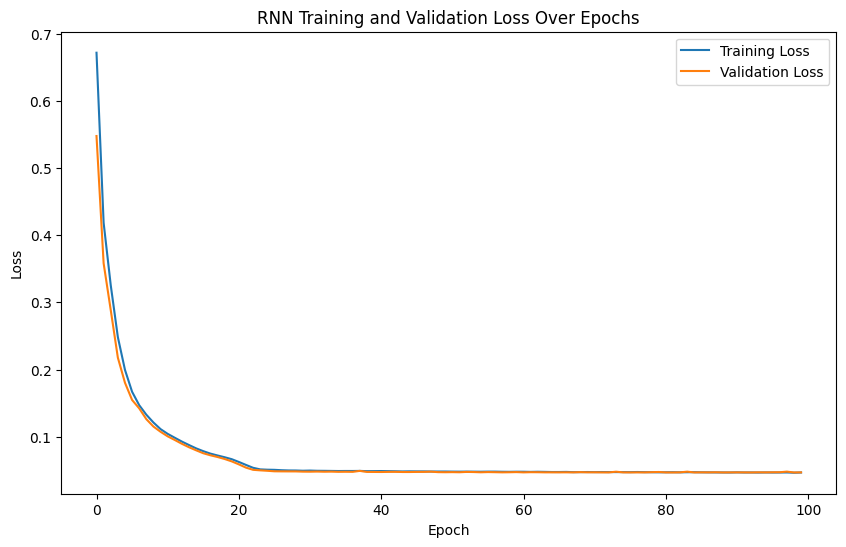

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Y_test shape
(326, 10)
Y_pred shape
(326, 10, 1)


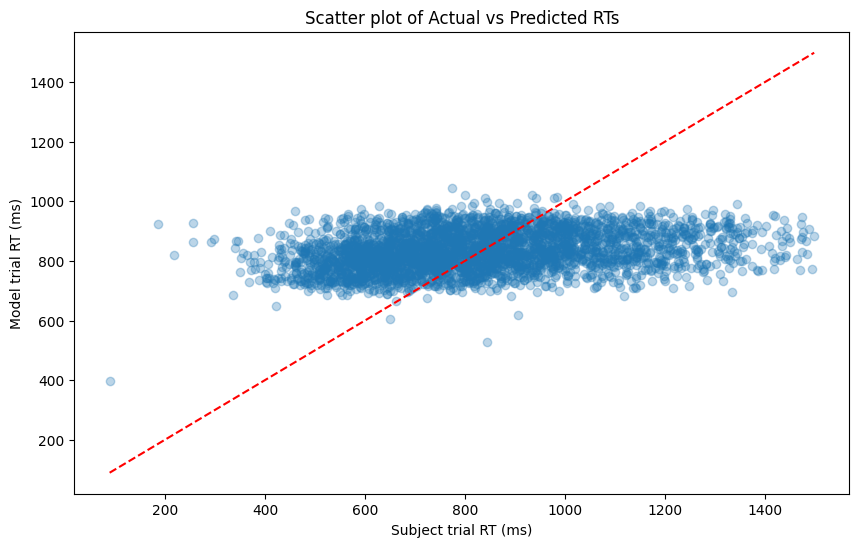

In [ ]:
# Model summary
model.summary()

# Training the model and capturing the history
history = model.fit(X_train_og, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

y_pred = model.predict(X_test_og)

print("Y_test shape")
print(y_test.shape)
print("Y_pred shape")
print(y_pred.shape)

# Convert predictions back to original scale
y_test_reshaped = y_test.reshape(-1) * 1000
y_pred_reshaped = y_pred.reshape(-1) * 1000

# Creating the scatter plot for Actual vs Predicted RTs
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reshaped, y_pred_reshaped, alpha=0.3)
plt.xlabel("Subject trial RT (ms)")
plt.ylabel("Model trial RT (ms)")
plt.title("Scatter plot of Actual vs Predicted RTs")
plt.plot([min(y_test_reshaped), max(y_test_reshaped)], [min(y_test_reshaped), max(y_test_reshaped)], color='red', linestyle='--')
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
print(f"Mean Squared Error: {mse}")

# Calculate switch cost and congruency effect for both subject and model
df_test = pd.DataFrame({
    "actual_rt": y_test_reshaped,
    "pred_rt": y_pred_reshaped,
    "switch_type": df_exp_1_input["switchType"].values[-len(y_test_reshaped):],
    "congruency": df_exp_1_input["stimCongruency"].values[-len(y_test_reshaped):]
})

# Method to calculate switch cost and congruency effect
def calculate_cost_effect(df, actual_col, pred_col):
    switch_cost_actual = df[df["switch_type"] == 1][actual_col].mean() - df[df["switch_type"] == 0][actual_col].mean()
    switch_cost_pred = df[df["switch_type"] == 1][pred_col].mean() - df[df["switch_type"] == 0][pred_col].mean()

    congruency_effect_actual = df[df["congruency"] == 0][actual_col].mean() - df[df["congruency"] == 1][actual_col].mean()
    congruency_effect_pred = df[df["congruency"] == 0][pred_col].mean() - df[df["congruency"] == 1][pred_col].mean()

    return switch_cost_actual, switch_cost_pred, congruency_effect_actual, congruency_effect_pred

switch_cost_actual, switch_cost_pred, congruency_effect_actual, congruency_effect_pred = calculate_cost_effect(df_test, "actual_rt", "pred_rt")
print(f"Switch Cost (Actual): {switch_cost_actual}")
print(f"Switch Cost (Predicted): {switch_cost_pred}")
print(f"Congruency Effect (Actual): {congruency_effect_actual}")


In [ ]:
# Compute the correlation coefficient
correlation = np.corrcoef(y_test_reshaped, y_pred_reshaped)[0, 1]

print(f"Correlation coefficient: {correlation}")

Mean Squared Error: 47791.73828125
Switch Cost (Actual): 15.0540771484375
Switch Cost (Predicted): -3.45367431640625
Congruency Effect (Actual): 4.2081298828125
Correlation coefficient: 0.27381261723169953


In [ ]:
X_test_subjects = X_test_subjects.reshape(-1)

In [ ]:
df_test = pd.DataFrame({
    "actual_rt": y_test_reshaped,
    "pred_rt": y_pred_reshaped,
    "switch_type": df_exp_1_input["switchType"].values[-len(y_test_reshaped):],
    "congruency": df_exp_1_input["stimCongruency"].values[-len(y_test_reshaped):],
    "subject": X_test_subjects
})
df_test

,actual_rt,pred_rt,switch_type,congruency,subject
0,787.000000,892.088684,1,0,Sub47
1,811.000000,897.374023,0,0,Sub47
2,923.000000,892.885071,1,0,Sub47
3,668.000000,836.083008,1,0,Sub47
4,693.000000,862.076538,1,0,Sub47
...,...,...,...,...,...
3255,523.000000,780.412415,1,0,Sub9
3256,521.000000,806.418213,1,0,Sub9
3257,514.000000,792.749023,1,1,Sub9
3258,503.000031,777.973328,0,0,Sub9


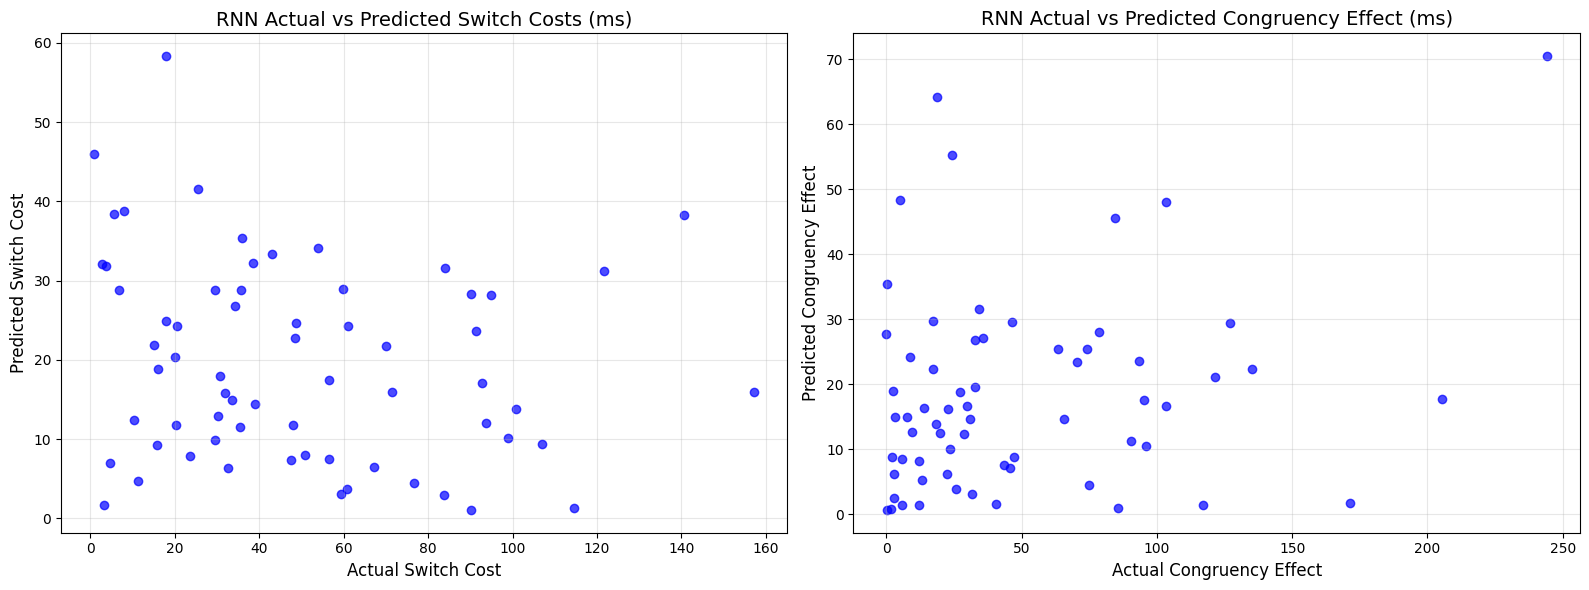

In [ ]:

# Step 1: Group by subject and switch_type
grouped_switch = df_test.groupby(["subject", "switch_type"])[["actual_rt", "pred_rt"]].mean().reset_index()
grouped_switch_pivot = grouped_switch.pivot(index="subject", columns="switch_type", values=["actual_rt", "pred_rt"]).reset_index()
grouped_switch_pivot.columns = ["subject", "actual_rt_when_switch_type_0", "actual_rt_when_switch_type_1", "pred_rt_when_switch_type_0", "pred_rt_when_switch_type_1"]
grouped_switch_pivot['actual_switch_cost'] = abs(grouped_switch_pivot['actual_rt_when_switch_type_1'] - grouped_switch_pivot['actual_rt_when_switch_type_0'])
grouped_switch_pivot['pred_switch_cost'] = abs(grouped_switch_pivot['pred_rt_when_switch_type_1'] - grouped_switch_pivot['pred_rt_when_switch_type_0'])

# Step 2: Group by subject and congruency
grouped_cong = df_test.groupby(["subject", "congruency"])[["actual_rt", "pred_rt"]].mean().reset_index()
grouped_cong_pivot = grouped_cong.pivot(index="subject", columns="congruency", values=["actual_rt", "pred_rt"]).reset_index()
grouped_cong_pivot.columns = ["subject", "actual_rt_when_congruency_0", "actual_rt_when_congruency_1", "pred_rt_when_congruency_0", "pred_rt_when_congruency_1"]
grouped_cong_pivot['actual_congruency_effect'] = abs(grouped_cong_pivot['actual_rt_when_congruency_1'] - grouped_cong_pivot['actual_rt_when_congruency_0'])
grouped_cong_pivot['pred_congruency_effect'] = abs(grouped_cong_pivot['pred_rt_when_congruency_1'] - grouped_cong_pivot['pred_rt_when_congruency_0'])

# Create subplots for side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter Plot of Actual vs Predicted Switch Costs
axes[0].scatter(grouped_switch_pivot["actual_switch_cost"], grouped_switch_pivot["pred_switch_cost"], color="blue", alpha=0.7)
max_value = max(grouped_switch_pivot["actual_switch_cost"].max(), grouped_switch_pivot["pred_switch_cost"].max())
min_value = min(grouped_switch_pivot["actual_switch_cost"].min(), grouped_switch_pivot["pred_switch_cost"].min())
# axes[0].plot([min_value, max_value], [min_value, max_value], color="red", linestyle="--", label="y=x")
axes[0].set_xlabel("Actual Switch Cost", fontsize=12)
axes[0].set_ylabel("Predicted Switch Cost", fontsize=12)
axes[0].set_title("RNN Actual vs Predicted Switch Costs (ms)", fontsize=14)
axes[0].grid(alpha=0.3)

# Plot 2: Scatter Plot of Actual vs Predicted Congruency Effect
axes[1].scatter(grouped_cong_pivot["actual_congruency_effect"], grouped_cong_pivot["pred_congruency_effect"], color="blue", alpha=0.7)
max_value = max(grouped_cong_pivot["actual_congruency_effect"].max(), grouped_cong_pivot["pred_congruency_effect"].max())
min_value = min(grouped_cong_pivot["actual_congruency_effect"].min(), grouped_cong_pivot["pred_congruency_effect"].min())
# axes[1].plot([min_value, max_value], [min_value, max_value], color="red", linestyle="--", label="y=x")
axes[1].set_xlabel("Actual Congruency Effect", fontsize=12)
axes[1].set_ylabel("Predicted Congruency Effect", fontsize=12)
axes[1].set_title("RNN Actual vs Predicted Congruency Effect (ms)", fontsize=14)
axes[1].grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


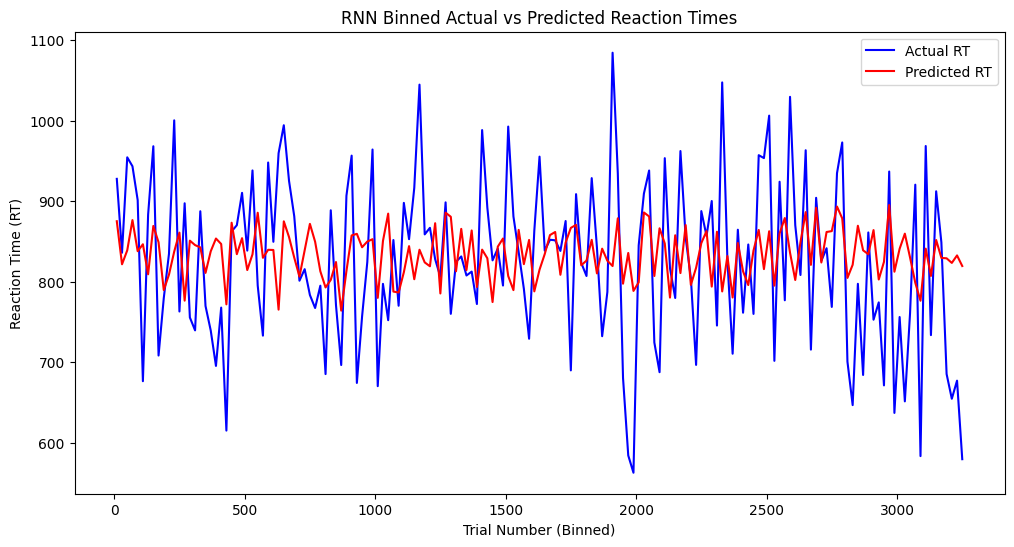

In [ ]:
bin_size = 20
num_bins = len(y_test_reshaped) // bin_size
trial_bins = np.arange(num_bins) * bin_size + bin_size // 2

actual_means = [y_test_reshaped[i*bin_size:(i+1)*bin_size].mean() for i in range(num_bins)]
predicted_means = [y_pred_reshaped[i*bin_size:(i+1)*bin_size].mean() for i in range(num_bins)]

plt.figure(figsize=(12, 6))
plt.plot(trial_bins, actual_means, label='Actual RT', color='blue')
plt.plot(trial_bins, predicted_means, label='Predicted RT', color='red')
plt.xlabel('Trial Number (Binned)')
plt.ylabel('Reaction Time (RT)')
plt.legend()
plt.title('RNN Binned Actual vs Predicted Reaction Times')
plt.show()